In [1]:
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
import tensorflow_hub as hub # pip install tensorflow-hub
from datetime import datetime

W0519 17:26:01.167964 140591241648000 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
!pip install bert-tensorflow
import bert # pip install bert-tensorflow
from bert import run_classifier
from bert import optimization
from bert import tokenization

     |████████████████████████████████| 71kB 2.8MB/s 


In [3]:
# Only run this if your doing this on colab, you will have to upload the data to drive too
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    :param cm: Confusion matrix
    :param classes: Python list of class names
    :param normalize: Boolean to normalize the matrix
    :param title: Title of the graph
    :param cmap: Colour map
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def create_model(is_predicting, #Bool to say if we're predicting (or training) as the output we'd like from the model would move
                 input_ids, # We know that our train_input_fn will pass the inputs as tensor of mini_batch_size, they
                 #actually come as one dictionary but in the next cell we see that in model_fn we split them out
                 input_mask, 
                 segment_ids, 
                 labels,
                 num_labels): # Num labels just lets us define the size of our softmax level for classification
    """Creates a classification model."""

    # Get the BERT model again from tf hub, this time setting trainable as true as we will fine tune it
    bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
    
    # We have our input tensors, the ones for the pre-trained bert are just being grouped here for convinience
    bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
    
    # We already saw earlier in the notebook, 'tokens' is the standard endpoint that gives the reference tensors coming out of BERT
    # Unlike 'tokenization_info' here we need to pass the inputs to get the outputs.
    bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

    # From the tf hub docs for BERT we know we can use "pooled_output" for classification tasks on an entire sentence.
    # Or use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

  # Create our own classification layer
    output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)
        
        print(output_layer.shape)
        print([BATCH_SIZE * MAX_SEQ_LENGTH, hidden_size])

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
              return (predicted_labels, log_probs)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, predicted_labels, log_probs)
      
      
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, 
                     learning_rate, 
                     num_train_steps,
                     num_warmup_steps):
    """Returns `model_fn` closure for TPUEstimator."""
    
    tf.reset_default_graph()

    def model_fn(features, 
                 labels, 
                 mode, 
                 params): 
        """The `model_fn` for TPUEstimator."""

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:

            # Here we run our model and return our loss function and friends
            (loss, predicted_labels, log_probs) = create_model(
            is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            # Here we define a training op, this one comes from BERT we will open this up in a second and have a look whats going on
            # but logically it makes sense what its doing, actually running the training
            train_op = bert.optimization.create_optimizer(
              loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

            # Calculate evaluation metrics and call them. This is a little subtle, the types of metrics we can use are limited to
            # tf's tf.metrics library which is definetly not exaustive (no multiclass f1 score...), as such what we can actually 
            # do is largely ignore this and calculate the metrics in python with the returned probabilites on the test set
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                return {"eval_accuracy": accuracy}

            eval_metrics = metric_fn(label_ids, predicted_labels)

            # Next we create a different end point for model_fn depending on what we're doing (training, predicting, etc)
            # All of these are instances of tf.estimator.EstimatorSpec which we will unpack below

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode,
                    loss=loss,
                    train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode,
                    loss=loss,
                    eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = create_model(
               is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            predictions = {
              'probabilities': log_probs,
              'labels': predicted_labels
            }
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn
  
  
def get_prediction(in_sentences):
  """
  Helper function to run the pipeline for a list of examples to classify
  """
  labels = ['Negative', 'Neutral', 'Positive']

  # As in 2.1. get input exaple objects in a list for every prediction example
  input_examples = [bert.run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 'Neutral') for x in in_sentences]

  # As in 2.3 convert to the classes that BERT will ultimately understand (still in python format here)
  input_features = bert.run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  # As in 3.2 we need an input function for the estimator, this just converts the data above to tensors to serve to the estimator
  predict_input_fn = bert.run_classifier.input_fn_builder(features=input_features, 
                                                          seq_length=MAX_SEQ_LENGTH, 
                                                          is_training=False, 
                                                          drop_remainder=False)

  # Run the model this time on .predict which as defined by our model_fn will return probabilities and labels
  predictions = estimator.predict(predict_input_fn)

  # Returns a list of tuples (sentence, probs, label) for each example we passed
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

    
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"


"""Get the vocab file and casing info from the Hub module."""
with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                              tokenization_info["do_lower_case"]])
        
tokenizer = bert.tokenization.FullTokenizer(vocab_file=vocab_file, 
                                            do_lower_case=do_lower_case)

print(tokenizer.tokenize("This here's an example of using the BERT tokenizer"))

vocab_df = pd.DataFrame(np.array([list(tokenizer.vocab.keys()), list(tokenizer.vocab.values())]).T, columns=["Vocab", "ID"])
print(vocab_df.sample(n=10))

DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
label_list = ['Negative', 'Neutral', 'Positive']

Instructions for updating:
Colocations handled automatically by placer.


W0519 17:26:39.656903 140591241648000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0519 17:26:41.949345 140591241648000 saver.py:1483] Saver not created because there are no variables in the graph to restore


['this', 'here', "'", 's', 'an', 'example', 'of', 'using', 'the', 'bert', 'token', '##izer']
            Vocab     ID
25379     ##tream  25379
10646    superman  10646
19472       khmer  19472
13483    interval  13483
16357        lars  16357
11857       mitch  11857
24901      ##trip  24901
13982  evacuation  13982
7734       dakota   7734
7663          nee   7663


# 1.0 Data

In [0]:
tasks = ['amazon_movies']#['amazon_movies', 'semeval_task_a']
sub_tasks = ['fair_balanced_100']#['fair_balanced_100', 'fair_balanced_1000'] #'fair_unbalanced_100', 'fair_unbalanced_300', 'fair_unbalanced_1000'

MAX_SEQ_LENGTH = 128

# Model configs
SAVE_CHECKPOINTS_STEPS = 10000
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1

learning_rates = [1e-4, 2e-5]#[1e-4, 5e-5, 3e-5, 2e-5, 1e-5] # [1e-4, 2e-4, 3e-4]
epochs = [3,10]#[3,4,5,10]

INFO:tensorflow:Writing example 0 of 300


I0519 19:17:56.455116 140591241648000 run_classifier.py:774] Writing example 0 of 300


INFO:tensorflow:*** Example ***


I0519 19:17:56.463603 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:17:56.468135 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] i was so excited to see this film because all the reviews had me tan ##tal ##ized . i do like the film , but i had two problems with it : < br / > < br / > 1 ) it was boring at parts . i started to fall asleep in the middle of the film ! i managed to stay awake , but it was not easy . maybe the dream ##y ether ##eal quality worked too well with me . or maybe i fell under the spell of hanging rock ! ? ! ? ! but seriously , it was difficult to sit through all at one time . < br / > 2 ) it was a little too ambiguous [SEP]


I0519 19:17:56.471564 140591241648000 run_classifier.py:464] tokens: [CLS] i was so excited to see this film because all the reviews had me tan ##tal ##ized . i do like the film , but i had two problems with it : < br / > < br / > 1 ) it was boring at parts . i started to fall asleep in the middle of the film ! i managed to stay awake , but it was not easy . maybe the dream ##y ether ##eal quality worked too well with me . or maybe i fell under the spell of hanging rock ! ? ! ? ! but seriously , it was difficult to sit through all at one time . < br / > 2 ) it was a little too ambiguous [SEP]


INFO:tensorflow:input_ids: 101 1045 2001 2061 7568 2000 2156 2023 2143 2138 2035 1996 4391 2018 2033 9092 9080 3550 1012 1045 2079 2066 1996 2143 1010 2021 1045 2018 2048 3471 2007 2009 1024 1026 7987 1013 1028 1026 7987 1013 1028 1015 1007 2009 2001 11771 2012 3033 1012 1045 2318 2000 2991 6680 1999 1996 2690 1997 1996 2143 999 1045 3266 2000 2994 8300 1010 2021 2009 2001 2025 3733 1012 2672 1996 3959 2100 28855 15879 3737 2499 2205 2092 2007 2033 1012 2030 2672 1045 3062 2104 1996 6297 1997 5689 2600 999 1029 999 1029 999 2021 5667 1010 2009 2001 3697 2000 4133 2083 2035 2012 2028 2051 1012 1026 7987 1013 1028 1016 1007 2009 2001 1037 2210 2205 20080 102


I0519 19:17:56.475117 140591241648000 run_classifier.py:465] input_ids: 101 1045 2001 2061 7568 2000 2156 2023 2143 2138 2035 1996 4391 2018 2033 9092 9080 3550 1012 1045 2079 2066 1996 2143 1010 2021 1045 2018 2048 3471 2007 2009 1024 1026 7987 1013 1028 1026 7987 1013 1028 1015 1007 2009 2001 11771 2012 3033 1012 1045 2318 2000 2991 6680 1999 1996 2690 1997 1996 2143 999 1045 3266 2000 2994 8300 1010 2021 2009 2001 2025 3733 1012 2672 1996 3959 2100 28855 15879 3737 2499 2205 2092 2007 2033 1012 2030 2672 1045 3062 2104 1996 6297 1997 5689 2600 999 1029 999 1029 999 2021 5667 1010 2009 2001 3697 2000 4133 2083 2035 2012 2028 2051 1012 1026 7987 1013 1028 1016 1007 2009 2001 1037 2210 2205 20080 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0519 19:17:56.478327 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:56.481462 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:17:56.485011 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0519 19:17:56.490828 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:17:56.493201 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] finally - - the answer to all the women here who were trained in dance and can ' t follow this dance card ##io dvd - - find out why you ' re not the cl ##utz you imagine as revealed in this 5 page review done by a dance and fitness expert . www . vent ##park . com and go to reviews park . < br / > < br / > once there ( it ' s free and no registration for reading ) you can find plenty of tracy anderson dvd reviews and join in on the tracy anderson method message board and discussion community already going on . enjoy ! [SEP]


I0519 19:17:56.495537 140591241648000 run_classifier.py:464] tokens: [CLS] finally - - the answer to all the women here who were trained in dance and can ' t follow this dance card ##io dvd - - find out why you ' re not the cl ##utz you imagine as revealed in this 5 page review done by a dance and fitness expert . www . vent ##park . com and go to reviews park . < br / > < br / > once there ( it ' s free and no registration for reading ) you can find plenty of tracy anderson dvd reviews and join in on the tracy anderson method message board and discussion community already going on . enjoy ! [SEP]


INFO:tensorflow:input_ids: 101 2633 1011 1011 1996 3437 2000 2035 1996 2308 2182 2040 2020 4738 1999 3153 1998 2064 1005 1056 3582 2023 3153 4003 3695 4966 1011 1011 2424 2041 2339 2017 1005 2128 2025 1996 18856 20267 2017 5674 2004 3936 1999 2023 1019 3931 3319 2589 2011 1037 3153 1998 10516 6739 1012 7479 1012 18834 14432 1012 4012 1998 2175 2000 4391 2380 1012 1026 7987 1013 1028 1026 7987 1013 1028 2320 2045 1006 2009 1005 1055 2489 1998 2053 8819 2005 3752 1007 2017 2064 2424 7564 1997 10555 5143 4966 4391 1998 3693 1999 2006 1996 10555 5143 4118 4471 2604 1998 6594 2451 2525 2183 2006 1012 5959 999 102 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:56.498242 140591241648000 run_classifier.py:465] input_ids: 101 2633 1011 1011 1996 3437 2000 2035 1996 2308 2182 2040 2020 4738 1999 3153 1998 2064 1005 1056 3582 2023 3153 4003 3695 4966 1011 1011 2424 2041 2339 2017 1005 2128 2025 1996 18856 20267 2017 5674 2004 3936 1999 2023 1019 3931 3319 2589 2011 1037 3153 1998 10516 6739 1012 7479 1012 18834 14432 1012 4012 1998 2175 2000 4391 2380 1012 1026 7987 1013 1028 1026 7987 1013 1028 2320 2045 1006 2009 1005 1055 2489 1998 2053 8819 2005 3752 1007 2017 2064 2424 7564 1997 10555 5143 4966 4391 1998 3693 1999 2006 1996 10555 5143 4118 4471 2604 1998 6594 2451 2525 2183 2006 1012 5959 999 102 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:56.500204 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:56.502074 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:17:56.503931 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0519 19:17:56.508093 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:17:56.509668 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this film is good were it keeps the audience attracted to it ' s events , actually i bought it because i think that mr . . conner ##y is one of the best actors . there are all ##ot of breath taking scenes in this movie , a try for creating a romantic story and a somehow this technological scenes . i think that this movie is good to watch if you do not have alternatives . but do not build hopes on it as i said it worth ##ies to be watched . [SEP]


I0519 19:17:56.511548 140591241648000 run_classifier.py:464] tokens: [CLS] this film is good were it keeps the audience attracted to it ' s events , actually i bought it because i think that mr . . conner ##y is one of the best actors . there are all ##ot of breath taking scenes in this movie , a try for creating a romantic story and a somehow this technological scenes . i think that this movie is good to watch if you do not have alternatives . but do not build hopes on it as i said it worth ##ies to be watched . [SEP]


INFO:tensorflow:input_ids: 101 2023 2143 2003 2204 2020 2009 7906 1996 4378 6296 2000 2009 1005 1055 2824 1010 2941 1045 4149 2009 2138 1045 2228 2008 2720 1012 1012 17639 2100 2003 2028 1997 1996 2190 5889 1012 2045 2024 2035 4140 1997 3052 2635 5019 1999 2023 3185 1010 1037 3046 2005 4526 1037 6298 2466 1998 1037 5064 2023 10660 5019 1012 1045 2228 2008 2023 3185 2003 2204 2000 3422 2065 2017 2079 2025 2031 15955 1012 2021 2079 2025 3857 8069 2006 2009 2004 1045 2056 2009 4276 3111 2000 2022 3427 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:56.513472 140591241648000 run_classifier.py:465] input_ids: 101 2023 2143 2003 2204 2020 2009 7906 1996 4378 6296 2000 2009 1005 1055 2824 1010 2941 1045 4149 2009 2138 1045 2228 2008 2720 1012 1012 17639 2100 2003 2028 1997 1996 2190 5889 1012 2045 2024 2035 4140 1997 3052 2635 5019 1999 2023 3185 1010 1037 3046 2005 4526 1037 6298 2466 1998 1037 5064 2023 10660 5019 1012 1045 2228 2008 2023 3185 2003 2204 2000 3422 2065 2017 2079 2025 2031 15955 1012 2021 2079 2025 3857 8069 2006 2009 2004 1045 2056 2009 4276 3111 2000 2022 3427 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:56.516112 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:56.517673 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Positive (id = 2)


I0519 19:17:56.519073 140591241648000 run_classifier.py:468] label: Positive (id = 2)


INFO:tensorflow:*** Example ***


I0519 19:17:56.525442 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:17:56.527241 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] . . . ' bout the birds and the bees , and the flowers and the trees , and the moon up above , ya ##da , ya ##da , ya ##da . we all know the song , just like we all know the kill bill saga is one long violent , bloody , amor ##al mess . i promised myself and my lord that i would not watch volume 2 , but my friend ' s daughters assured me that the second half was far superior . < br / > < br / > friends and fans ( of my reviews ! unite ! ) , let me tell you this movie is even more violent and disturbing than the first one . [SEP]


I0519 19:17:56.528705 140591241648000 run_classifier.py:464] tokens: [CLS] . . . ' bout the birds and the bees , and the flowers and the trees , and the moon up above , ya ##da , ya ##da , ya ##da . we all know the song , just like we all know the kill bill saga is one long violent , bloody , amor ##al mess . i promised myself and my lord that i would not watch volume 2 , but my friend ' s daughters assured me that the second half was far superior . < br / > < br / > friends and fans ( of my reviews ! unite ! ) , let me tell you this movie is even more violent and disturbing than the first one . [SEP]


INFO:tensorflow:input_ids: 101 1012 1012 1012 1005 10094 1996 5055 1998 1996 13734 1010 1998 1996 4870 1998 1996 3628 1010 1998 1996 4231 2039 2682 1010 8038 2850 1010 8038 2850 1010 8038 2850 1012 2057 2035 2113 1996 2299 1010 2074 2066 2057 2035 2113 1996 3102 3021 12312 2003 2028 2146 6355 1010 6703 1010 16095 2389 6752 1012 1045 5763 2870 1998 2026 2935 2008 1045 2052 2025 3422 3872 1016 1010 2021 2026 2767 1005 1055 5727 8916 2033 2008 1996 2117 2431 2001 2521 6020 1012 1026 7987 1013 1028 1026 7987 1013 1028 2814 1998 4599 1006 1997 2026 4391 999 15908 999 1007 1010 2292 2033 2425 2017 2023 3185 2003 2130 2062 6355 1998 14888 2084 1996 2034 2028 1012 102


I0519 19:17:56.530174 140591241648000 run_classifier.py:465] input_ids: 101 1012 1012 1012 1005 10094 1996 5055 1998 1996 13734 1010 1998 1996 4870 1998 1996 3628 1010 1998 1996 4231 2039 2682 1010 8038 2850 1010 8038 2850 1010 8038 2850 1012 2057 2035 2113 1996 2299 1010 2074 2066 2057 2035 2113 1996 3102 3021 12312 2003 2028 2146 6355 1010 6703 1010 16095 2389 6752 1012 1045 5763 2870 1998 2026 2935 2008 1045 2052 2025 3422 3872 1016 1010 2021 2026 2767 1005 1055 5727 8916 2033 2008 1996 2117 2431 2001 2521 6020 1012 1026 7987 1013 1028 1026 7987 1013 1028 2814 1998 4599 1006 1997 2026 4391 999 15908 999 1007 1010 2292 2033 2425 2017 2023 3185 2003 2130 2062 6355 1998 14888 2084 1996 2034 2028 1012 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0519 19:17:56.531470 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:56.532906 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Negative (id = 0)


I0519 19:17:56.534138 140591241648000 run_classifier.py:468] label: Negative (id = 0)


INFO:tensorflow:*** Example ***


I0519 19:17:56.536642 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:17:56.537967 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] the maya civilization ceased to exist before the coming of the europeans , what would have been a decent movie was ruined by placing the europeans in that time period thereby suggesting that the europeans played a part in the maya ##n civilization demise . [SEP]


I0519 19:17:56.539248 140591241648000 run_classifier.py:464] tokens: [CLS] the maya civilization ceased to exist before the coming of the europeans , what would have been a decent movie was ruined by placing the europeans in that time period thereby suggesting that the europeans played a part in the maya ##n civilization demise . [SEP]


INFO:tensorflow:input_ids: 101 1996 9815 10585 7024 2000 4839 2077 1996 2746 1997 1996 13481 1010 2054 2052 2031 2042 1037 11519 3185 2001 9868 2011 6885 1996 13481 1999 2008 2051 2558 8558 9104 2008 1996 13481 2209 1037 2112 1999 1996 9815 2078 10585 13614 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:56.540556 140591241648000 run_classifier.py:465] input_ids: 101 1996 9815 10585 7024 2000 4839 2077 1996 2746 1997 1996 13481 1010 2054 2052 2031 2042 1037 11519 3185 2001 9868 2011 6885 1996 13481 1999 2008 2051 2558 8558 9104 2008 1996 13481 2209 1037 2112 1999 1996 9815 2078 10585 13614 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:56.541895 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:56.543171 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:17:56.544410 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:Writing example 0 of 15000


I0519 19:17:57.662335 140591241648000 run_classifier.py:774] Writing example 0 of 15000


INFO:tensorflow:*** Example ***


I0519 19:17:57.668796 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:17:57.671013 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] i have to say that if you want to see fu ##lc ##i ' s masterpiece , check out the beyond ( before you see this ) . there just isn ' t much gore here . however , lots of hot girls get naked and get it on . i was surprised at the amount of sex scenes , which is what saved it from a 2 star rating . the killer ' s duck voice is very funny , but i found the amount of blood ##shed di ##ssa ##point ##ing . only a few good scenes of cutting up girls . if you are a gore hound i would suggest looking elsewhere . [SEP]


I0519 19:17:57.673409 140591241648000 run_classifier.py:464] tokens: [CLS] i have to say that if you want to see fu ##lc ##i ' s masterpiece , check out the beyond ( before you see this ) . there just isn ' t much gore here . however , lots of hot girls get naked and get it on . i was surprised at the amount of sex scenes , which is what saved it from a 2 star rating . the killer ' s duck voice is very funny , but i found the amount of blood ##shed di ##ssa ##point ##ing . only a few good scenes of cutting up girls . if you are a gore hound i would suggest looking elsewhere . [SEP]


INFO:tensorflow:input_ids: 101 1045 2031 2000 2360 2008 2065 2017 2215 2000 2156 11865 15472 2072 1005 1055 17743 1010 4638 2041 1996 3458 1006 2077 2017 2156 2023 1007 1012 2045 2074 3475 1005 1056 2172 13638 2182 1012 2174 1010 7167 1997 2980 3057 2131 6248 1998 2131 2009 2006 1012 1045 2001 4527 2012 1996 3815 1997 3348 5019 1010 2029 2003 2054 5552 2009 2013 1037 1016 2732 5790 1012 1996 6359 1005 1055 9457 2376 2003 2200 6057 1010 2021 1045 2179 1996 3815 1997 2668 14740 4487 11488 8400 2075 1012 2069 1037 2261 2204 5019 1997 6276 2039 3057 1012 2065 2017 2024 1037 13638 19598 1045 2052 6592 2559 6974 1012 102 0 0 0 0 0 0 0 0 0 0


I0519 19:17:57.675878 140591241648000 run_classifier.py:465] input_ids: 101 1045 2031 2000 2360 2008 2065 2017 2215 2000 2156 11865 15472 2072 1005 1055 17743 1010 4638 2041 1996 3458 1006 2077 2017 2156 2023 1007 1012 2045 2074 3475 1005 1056 2172 13638 2182 1012 2174 1010 7167 1997 2980 3057 2131 6248 1998 2131 2009 2006 1012 1045 2001 4527 2012 1996 3815 1997 3348 5019 1010 2029 2003 2054 5552 2009 2013 1037 1016 2732 5790 1012 1996 6359 1005 1055 9457 2376 2003 2200 6057 1010 2021 1045 2179 1996 3815 1997 2668 14740 4487 11488 8400 2075 1012 2069 1037 2261 2204 5019 1997 6276 2039 3057 1012 2065 2017 2024 1037 13638 19598 1045 2052 6592 2559 6974 1012 102 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0


I0519 19:17:57.678079 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:57.680464 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:17:57.682573 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0519 19:17:57.688935 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:17:57.691213 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] robert he ##in ##lein wrote the original stars ##hip trooper as a < br / > satire of military space operas . now it seems to be living on as < br / > a movie series that makes fun of itself and war efforts everywhere . < br / > in the bug war , war is literally hell . < br / > in this case the super - mind bug brain ##wash ##es the singing field marshal < br / > into thinking there is a bug god . < br / > a q - bomb ( something like 100 russian 100 mega ##ton bombs ) finish ##s the < br / > god - bug that takes up half a planet [SEP]


I0519 19:17:57.693652 140591241648000 run_classifier.py:464] tokens: [CLS] robert he ##in ##lein wrote the original stars ##hip trooper as a < br / > satire of military space operas . now it seems to be living on as < br / > a movie series that makes fun of itself and war efforts everywhere . < br / > in the bug war , war is literally hell . < br / > in this case the super - mind bug brain ##wash ##es the singing field marshal < br / > into thinking there is a bug god . < br / > a q - bomb ( something like 100 russian 100 mega ##ton bombs ) finish ##s the < br / > god - bug that takes up half a planet [SEP]


INFO:tensorflow:input_ids: 101 2728 2002 2378 19856 2626 1996 2434 3340 5605 28224 2004 1037 1026 7987 1013 1028 18312 1997 2510 2686 14281 1012 2085 2009 3849 2000 2022 2542 2006 2004 1026 7987 1013 1028 1037 3185 2186 2008 3084 4569 1997 2993 1998 2162 4073 7249 1012 1026 7987 1013 1028 1999 1996 11829 2162 1010 2162 2003 6719 3109 1012 1026 7987 1013 1028 1999 2023 2553 1996 3565 1011 2568 11829 4167 28556 2229 1996 4823 2492 8610 1026 7987 1013 1028 2046 3241 2045 2003 1037 11829 2643 1012 1026 7987 1013 1028 1037 1053 1011 5968 1006 2242 2066 2531 2845 2531 13164 2669 9767 1007 3926 2015 1996 1026 7987 1013 1028 2643 1011 11829 2008 3138 2039 2431 1037 4774 102


I0519 19:17:57.695790 140591241648000 run_classifier.py:465] input_ids: 101 2728 2002 2378 19856 2626 1996 2434 3340 5605 28224 2004 1037 1026 7987 1013 1028 18312 1997 2510 2686 14281 1012 2085 2009 3849 2000 2022 2542 2006 2004 1026 7987 1013 1028 1037 3185 2186 2008 3084 4569 1997 2993 1998 2162 4073 7249 1012 1026 7987 1013 1028 1999 1996 11829 2162 1010 2162 2003 6719 3109 1012 1026 7987 1013 1028 1999 2023 2553 1996 3565 1011 2568 11829 4167 28556 2229 1996 4823 2492 8610 1026 7987 1013 1028 2046 3241 2045 2003 1037 11829 2643 1012 1026 7987 1013 1028 1037 1053 1011 5968 1006 2242 2066 2531 2845 2531 13164 2669 9767 1007 3926 2015 1996 1026 7987 1013 1028 2643 1011 11829 2008 3138 2039 2431 1037 4774 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0519 19:17:57.698089 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:57.700011 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:17:57.702928 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0519 19:17:57.715890 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:17:57.718011 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] the true test of whether or not to buy a dvd is whether or not you will watch the film three times within the next three years . the forgotten is one of those movies that is definitely worth a second viewing , but i ' m on the fence about whether or not it would pass the 3 ##x ##3 rule . < br / > < br / > first , julian ##ne moore as tell ##y does a great job . because of the snow ##storm ##s recently , we ' ve been sock ##ed in the house and have had a chance to see the village , cellular , and the forgotten in pretty short order . i ' m rating the [SEP]


I0519 19:17:57.720410 140591241648000 run_classifier.py:464] tokens: [CLS] the true test of whether or not to buy a dvd is whether or not you will watch the film three times within the next three years . the forgotten is one of those movies that is definitely worth a second viewing , but i ' m on the fence about whether or not it would pass the 3 ##x ##3 rule . < br / > < br / > first , julian ##ne moore as tell ##y does a great job . because of the snow ##storm ##s recently , we ' ve been sock ##ed in the house and have had a chance to see the village , cellular , and the forgotten in pretty short order . i ' m rating the [SEP]


INFO:tensorflow:input_ids: 101 1996 2995 3231 1997 3251 2030 2025 2000 4965 1037 4966 2003 3251 2030 2025 2017 2097 3422 1996 2143 2093 2335 2306 1996 2279 2093 2086 1012 1996 6404 2003 2028 1997 2216 5691 2008 2003 5791 4276 1037 2117 10523 1010 2021 1045 1005 1049 2006 1996 8638 2055 3251 2030 2025 2009 2052 3413 1996 1017 2595 2509 3627 1012 1026 7987 1013 1028 1026 7987 1013 1028 2034 1010 6426 2638 5405 2004 2425 2100 2515 1037 2307 3105 1012 2138 1997 1996 4586 19718 2015 3728 1010 2057 1005 2310 2042 28407 2098 1999 1996 2160 1998 2031 2018 1037 3382 2000 2156 1996 2352 1010 12562 1010 1998 1996 6404 1999 3492 2460 2344 1012 1045 1005 1049 5790 1996 102


I0519 19:17:57.722745 140591241648000 run_classifier.py:465] input_ids: 101 1996 2995 3231 1997 3251 2030 2025 2000 4965 1037 4966 2003 3251 2030 2025 2017 2097 3422 1996 2143 2093 2335 2306 1996 2279 2093 2086 1012 1996 6404 2003 2028 1997 2216 5691 2008 2003 5791 4276 1037 2117 10523 1010 2021 1045 1005 1049 2006 1996 8638 2055 3251 2030 2025 2009 2052 3413 1996 1017 2595 2509 3627 1012 1026 7987 1013 1028 1026 7987 1013 1028 2034 1010 6426 2638 5405 2004 2425 2100 2515 1037 2307 3105 1012 2138 1997 1996 4586 19718 2015 3728 1010 2057 1005 2310 2042 28407 2098 1999 1996 2160 1998 2031 2018 1037 3382 2000 2156 1996 2352 1010 12562 1010 1998 1996 6404 1999 3492 2460 2344 1012 1045 1005 1049 5790 1996 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0519 19:17:57.725171 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:57.727552 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:17:57.729504 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0519 19:17:57.735025 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:17:57.737167 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] i have watched this movie numerous times . each time i watch it i see something new . i have found that the movie echoes to some degree the life of elvis from the time he began a recording carr ##er on through his movie days . it also shows how two - faced the music industry could be . for those of you that have only seen the movie once or twice , i urge you to watch it un - interrupted . maybe you too will see what i am talking about . i promise that you will not be disappointed . others say elvis can ' t act . watch this movie and you be the judge . [SEP]


I0519 19:17:57.739332 140591241648000 run_classifier.py:464] tokens: [CLS] i have watched this movie numerous times . each time i watch it i see something new . i have found that the movie echoes to some degree the life of elvis from the time he began a recording carr ##er on through his movie days . it also shows how two - faced the music industry could be . for those of you that have only seen the movie once or twice , i urge you to watch it un - interrupted . maybe you too will see what i am talking about . i promise that you will not be disappointed . others say elvis can ' t act . watch this movie and you be the judge . [SEP]


INFO:tensorflow:input_ids: 101 1045 2031 3427 2023 3185 3365 2335 1012 2169 2051 1045 3422 2009 1045 2156 2242 2047 1012 1045 2031 2179 2008 1996 3185 17659 2000 2070 3014 1996 2166 1997 12280 2013 1996 2051 2002 2211 1037 3405 12385 2121 2006 2083 2010 3185 2420 1012 2009 2036 3065 2129 2048 1011 4320 1996 2189 3068 2071 2022 1012 2005 2216 1997 2017 2008 2031 2069 2464 1996 3185 2320 2030 3807 1010 1045 9075 2017 2000 3422 2009 4895 1011 7153 1012 2672 2017 2205 2097 2156 2054 1045 2572 3331 2055 1012 1045 4872 2008 2017 2097 2025 2022 9364 1012 2500 2360 12280 2064 1005 1056 2552 1012 3422 2023 3185 1998 2017 2022 1996 3648 1012 102 0 0 0 0 0


I0519 19:17:57.741376 140591241648000 run_classifier.py:465] input_ids: 101 1045 2031 3427 2023 3185 3365 2335 1012 2169 2051 1045 3422 2009 1045 2156 2242 2047 1012 1045 2031 2179 2008 1996 3185 17659 2000 2070 3014 1996 2166 1997 12280 2013 1996 2051 2002 2211 1037 3405 12385 2121 2006 2083 2010 3185 2420 1012 2009 2036 3065 2129 2048 1011 4320 1996 2189 3068 2071 2022 1012 2005 2216 1997 2017 2008 2031 2069 2464 1996 3185 2320 2030 3807 1010 1045 9075 2017 2000 3422 2009 4895 1011 7153 1012 2672 2017 2205 2097 2156 2054 1045 2572 3331 2055 1012 1045 4872 2008 2017 2097 2025 2022 9364 1012 2500 2360 12280 2064 1005 1056 2552 1012 3422 2023 3185 1998 2017 2022 1996 3648 1012 102 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0


I0519 19:17:57.743713 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:57.745941 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Positive (id = 2)


I0519 19:17:57.748127 140591241648000 run_classifier.py:468] label: Positive (id = 2)


INFO:tensorflow:*** Example ***


I0519 19:17:57.755103 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:17:57.757499 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] personally speaking , as a huge fan of buffy from the beginning , i found this season to be the best . the characters had started to develop as we get to know more about them especially cord ##elia on how she ' s not all that shallow ! = p as a buffy and angel fan , that is one reason why i loved this season soo much . seeing buffy lose her innocence to the man / vamp she loves and to be the reason for angel going all * dr ##ool * evil ##ly angel ##us just broke my heart ! < p > the fight scene in the finale in becoming part 2 just kicked - butt ! a lot of action [SEP]


I0519 19:17:57.759840 140591241648000 run_classifier.py:464] tokens: [CLS] personally speaking , as a huge fan of buffy from the beginning , i found this season to be the best . the characters had started to develop as we get to know more about them especially cord ##elia on how she ' s not all that shallow ! = p as a buffy and angel fan , that is one reason why i loved this season soo much . seeing buffy lose her innocence to the man / vamp she loves and to be the reason for angel going all * dr ##ool * evil ##ly angel ##us just broke my heart ! < p > the fight scene in the finale in becoming part 2 just kicked - butt ! a lot of action [SEP]


INFO:tensorflow:input_ids: 101 7714 4092 1010 2004 1037 4121 5470 1997 18467 2013 1996 2927 1010 1045 2179 2023 2161 2000 2022 1996 2190 1012 1996 3494 2018 2318 2000 4503 2004 2057 2131 2000 2113 2062 2055 2068 2926 11601 13902 2006 2129 2016 1005 1055 2025 2035 2008 8467 999 1027 1052 2004 1037 18467 1998 4850 5470 1010 2008 2003 2028 3114 2339 1045 3866 2023 2161 17111 2172 1012 3773 18467 4558 2014 12660 2000 1996 2158 1013 20279 2016 7459 1998 2000 2022 1996 3114 2005 4850 2183 2035 1008 2852 13669 1008 4763 2135 4850 2271 2074 3631 2026 2540 999 1026 1052 1028 1996 2954 3496 1999 1996 9599 1999 3352 2112 1016 2074 6476 1011 10007 999 1037 2843 1997 2895 102


I0519 19:17:57.761931 140591241648000 run_classifier.py:465] input_ids: 101 7714 4092 1010 2004 1037 4121 5470 1997 18467 2013 1996 2927 1010 1045 2179 2023 2161 2000 2022 1996 2190 1012 1996 3494 2018 2318 2000 4503 2004 2057 2131 2000 2113 2062 2055 2068 2926 11601 13902 2006 2129 2016 1005 1055 2025 2035 2008 8467 999 1027 1052 2004 1037 18467 1998 4850 5470 1010 2008 2003 2028 3114 2339 1045 3866 2023 2161 17111 2172 1012 3773 18467 4558 2014 12660 2000 1996 2158 1013 20279 2016 7459 1998 2000 2022 1996 3114 2005 4850 2183 2035 1008 2852 13669 1008 4763 2135 4850 2271 2074 3631 2026 2540 999 1026 1052 1028 1996 2954 3496 1999 1996 9599 1999 3352 2112 1016 2074 6476 1011 10007 999 1037 2843 1997 2895 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0519 19:17:57.764233 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:17:57.766293 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Positive (id = 2)


I0519 19:17:57.768596 140591241648000 run_classifier.py:468] label: Positive (id = 2)


INFO:tensorflow:Writing example 10000 of 15000


I0519 19:18:38.946816 140591241648000 run_classifier.py:774] Writing example 10000 of 15000


28
2
INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdd507f9b70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0519 19:18:59.156231 140591241648000 estimator.py:201] Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdd507f9b70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Beginning Training!
INFO:tensorflow:Skipping training since max_steps has already saved.


I0519 19:18:59.170490 140591241648000 estimator.py:351] Skipping training since max_steps has already saved.


Training took time  0:00:00.013153
INFO:tensorflow:Writing example 0 of 15000


I0519 19:18:59.278190 140591241648000 run_classifier.py:774] Writing example 0 of 15000


INFO:tensorflow:*** Example ***


I0519 19:18:59.282681 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0519 19:18:59.286301 140591241648000 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] i have to say that if you want to see fu ##lc ##i ' s masterpiece , check out the beyond ( before you see this ) . there just isn ' t much gore here . however , lots of hot girls get naked and get it on . i was surprised at the amount of sex scenes , which is what saved it from a 2 star rating . the killer ' s duck voice is very funny , but i found the amount of blood ##shed di ##ssa ##point ##ing . only a few good scenes of cutting up girls . if you are a gore hound i would suggest looking elsewhere . [SEP]


I0519 19:18:59.290335 140591241648000 run_classifier.py:464] tokens: [CLS] i have to say that if you want to see fu ##lc ##i ' s masterpiece , check out the beyond ( before you see this ) . there just isn ' t much gore here . however , lots of hot girls get naked and get it on . i was surprised at the amount of sex scenes , which is what saved it from a 2 star rating . the killer ' s duck voice is very funny , but i found the amount of blood ##shed di ##ssa ##point ##ing . only a few good scenes of cutting up girls . if you are a gore hound i would suggest looking elsewhere . [SEP]


INFO:tensorflow:input_ids: 101 1045 2031 2000 2360 2008 2065 2017 2215 2000 2156 11865 15472 2072 1005 1055 17743 1010 4638 2041 1996 3458 1006 2077 2017 2156 2023 1007 1012 2045 2074 3475 1005 1056 2172 13638 2182 1012 2174 1010 7167 1997 2980 3057 2131 6248 1998 2131 2009 2006 1012 1045 2001 4527 2012 1996 3815 1997 3348 5019 1010 2029 2003 2054 5552 2009 2013 1037 1016 2732 5790 1012 1996 6359 1005 1055 9457 2376 2003 2200 6057 1010 2021 1045 2179 1996 3815 1997 2668 14740 4487 11488 8400 2075 1012 2069 1037 2261 2204 5019 1997 6276 2039 3057 1012 2065 2017 2024 1037 13638 19598 1045 2052 6592 2559 6974 1012 102 0 0 0 0 0 0 0 0 0 0


I0519 19:18:59.293925 140591241648000 run_classifier.py:465] input_ids: 101 1045 2031 2000 2360 2008 2065 2017 2215 2000 2156 11865 15472 2072 1005 1055 17743 1010 4638 2041 1996 3458 1006 2077 2017 2156 2023 1007 1012 2045 2074 3475 1005 1056 2172 13638 2182 1012 2174 1010 7167 1997 2980 3057 2131 6248 1998 2131 2009 2006 1012 1045 2001 4527 2012 1996 3815 1997 3348 5019 1010 2029 2003 2054 5552 2009 2013 1037 1016 2732 5790 1012 1996 6359 1005 1055 9457 2376 2003 2200 6057 1010 2021 1045 2179 1996 3815 1997 2668 14740 4487 11488 8400 2075 1012 2069 1037 2261 2204 5019 1997 6276 2039 3057 1012 2065 2017 2024 1037 13638 19598 1045 2052 6592 2559 6974 1012 102 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0


I0519 19:18:59.297466 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:18:59.301208 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:18:59.303697 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0519 19:18:59.313139 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0519 19:18:59.315432 140591241648000 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] robert he ##in ##lein wrote the original stars ##hip trooper as a < br / > satire of military space operas . now it seems to be living on as < br / > a movie series that makes fun of itself and war efforts everywhere . < br / > in the bug war , war is literally hell . < br / > in this case the super - mind bug brain ##wash ##es the singing field marshal < br / > into thinking there is a bug god . < br / > a q - bomb ( something like 100 russian 100 mega ##ton bombs ) finish ##s the < br / > god - bug that takes up half a planet [SEP]


I0519 19:18:59.318604 140591241648000 run_classifier.py:464] tokens: [CLS] robert he ##in ##lein wrote the original stars ##hip trooper as a < br / > satire of military space operas . now it seems to be living on as < br / > a movie series that makes fun of itself and war efforts everywhere . < br / > in the bug war , war is literally hell . < br / > in this case the super - mind bug brain ##wash ##es the singing field marshal < br / > into thinking there is a bug god . < br / > a q - bomb ( something like 100 russian 100 mega ##ton bombs ) finish ##s the < br / > god - bug that takes up half a planet [SEP]


INFO:tensorflow:input_ids: 101 2728 2002 2378 19856 2626 1996 2434 3340 5605 28224 2004 1037 1026 7987 1013 1028 18312 1997 2510 2686 14281 1012 2085 2009 3849 2000 2022 2542 2006 2004 1026 7987 1013 1028 1037 3185 2186 2008 3084 4569 1997 2993 1998 2162 4073 7249 1012 1026 7987 1013 1028 1999 1996 11829 2162 1010 2162 2003 6719 3109 1012 1026 7987 1013 1028 1999 2023 2553 1996 3565 1011 2568 11829 4167 28556 2229 1996 4823 2492 8610 1026 7987 1013 1028 2046 3241 2045 2003 1037 11829 2643 1012 1026 7987 1013 1028 1037 1053 1011 5968 1006 2242 2066 2531 2845 2531 13164 2669 9767 1007 3926 2015 1996 1026 7987 1013 1028 2643 1011 11829 2008 3138 2039 2431 1037 4774 102


I0519 19:18:59.321720 140591241648000 run_classifier.py:465] input_ids: 101 2728 2002 2378 19856 2626 1996 2434 3340 5605 28224 2004 1037 1026 7987 1013 1028 18312 1997 2510 2686 14281 1012 2085 2009 3849 2000 2022 2542 2006 2004 1026 7987 1013 1028 1037 3185 2186 2008 3084 4569 1997 2993 1998 2162 4073 7249 1012 1026 7987 1013 1028 1999 1996 11829 2162 1010 2162 2003 6719 3109 1012 1026 7987 1013 1028 1999 2023 2553 1996 3565 1011 2568 11829 4167 28556 2229 1996 4823 2492 8610 1026 7987 1013 1028 2046 3241 2045 2003 1037 11829 2643 1012 1026 7987 1013 1028 1037 1053 1011 5968 1006 2242 2066 2531 2845 2531 13164 2669 9767 1007 3926 2015 1996 1026 7987 1013 1028 2643 1011 11829 2008 3138 2039 2431 1037 4774 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0519 19:18:59.325082 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:18:59.328124 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:18:59.331389 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0519 19:18:59.348786 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0519 19:18:59.351229 140591241648000 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] the true test of whether or not to buy a dvd is whether or not you will watch the film three times within the next three years . the forgotten is one of those movies that is definitely worth a second viewing , but i ' m on the fence about whether or not it would pass the 3 ##x ##3 rule . < br / > < br / > first , julian ##ne moore as tell ##y does a great job . because of the snow ##storm ##s recently , we ' ve been sock ##ed in the house and have had a chance to see the village , cellular , and the forgotten in pretty short order . i ' m rating the [SEP]


I0519 19:18:59.355192 140591241648000 run_classifier.py:464] tokens: [CLS] the true test of whether or not to buy a dvd is whether or not you will watch the film three times within the next three years . the forgotten is one of those movies that is definitely worth a second viewing , but i ' m on the fence about whether or not it would pass the 3 ##x ##3 rule . < br / > < br / > first , julian ##ne moore as tell ##y does a great job . because of the snow ##storm ##s recently , we ' ve been sock ##ed in the house and have had a chance to see the village , cellular , and the forgotten in pretty short order . i ' m rating the [SEP]


INFO:tensorflow:input_ids: 101 1996 2995 3231 1997 3251 2030 2025 2000 4965 1037 4966 2003 3251 2030 2025 2017 2097 3422 1996 2143 2093 2335 2306 1996 2279 2093 2086 1012 1996 6404 2003 2028 1997 2216 5691 2008 2003 5791 4276 1037 2117 10523 1010 2021 1045 1005 1049 2006 1996 8638 2055 3251 2030 2025 2009 2052 3413 1996 1017 2595 2509 3627 1012 1026 7987 1013 1028 1026 7987 1013 1028 2034 1010 6426 2638 5405 2004 2425 2100 2515 1037 2307 3105 1012 2138 1997 1996 4586 19718 2015 3728 1010 2057 1005 2310 2042 28407 2098 1999 1996 2160 1998 2031 2018 1037 3382 2000 2156 1996 2352 1010 12562 1010 1998 1996 6404 1999 3492 2460 2344 1012 1045 1005 1049 5790 1996 102


I0519 19:18:59.358930 140591241648000 run_classifier.py:465] input_ids: 101 1996 2995 3231 1997 3251 2030 2025 2000 4965 1037 4966 2003 3251 2030 2025 2017 2097 3422 1996 2143 2093 2335 2306 1996 2279 2093 2086 1012 1996 6404 2003 2028 1997 2216 5691 2008 2003 5791 4276 1037 2117 10523 1010 2021 1045 1005 1049 2006 1996 8638 2055 3251 2030 2025 2009 2052 3413 1996 1017 2595 2509 3627 1012 1026 7987 1013 1028 1026 7987 1013 1028 2034 1010 6426 2638 5405 2004 2425 2100 2515 1037 2307 3105 1012 2138 1997 1996 4586 19718 2015 3728 1010 2057 1005 2310 2042 28407 2098 1999 1996 2160 1998 2031 2018 1037 3382 2000 2156 1996 2352 1010 12562 1010 1998 1996 6404 1999 3492 2460 2344 1012 1045 1005 1049 5790 1996 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0519 19:18:59.363597 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:18:59.366547 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:18:59.370257 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0519 19:18:59.377154 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0519 19:18:59.378830 140591241648000 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] i have watched this movie numerous times . each time i watch it i see something new . i have found that the movie echoes to some degree the life of elvis from the time he began a recording carr ##er on through his movie days . it also shows how two - faced the music industry could be . for those of you that have only seen the movie once or twice , i urge you to watch it un - interrupted . maybe you too will see what i am talking about . i promise that you will not be disappointed . others say elvis can ' t act . watch this movie and you be the judge . [SEP]


I0519 19:18:59.381884 140591241648000 run_classifier.py:464] tokens: [CLS] i have watched this movie numerous times . each time i watch it i see something new . i have found that the movie echoes to some degree the life of elvis from the time he began a recording carr ##er on through his movie days . it also shows how two - faced the music industry could be . for those of you that have only seen the movie once or twice , i urge you to watch it un - interrupted . maybe you too will see what i am talking about . i promise that you will not be disappointed . others say elvis can ' t act . watch this movie and you be the judge . [SEP]


INFO:tensorflow:input_ids: 101 1045 2031 3427 2023 3185 3365 2335 1012 2169 2051 1045 3422 2009 1045 2156 2242 2047 1012 1045 2031 2179 2008 1996 3185 17659 2000 2070 3014 1996 2166 1997 12280 2013 1996 2051 2002 2211 1037 3405 12385 2121 2006 2083 2010 3185 2420 1012 2009 2036 3065 2129 2048 1011 4320 1996 2189 3068 2071 2022 1012 2005 2216 1997 2017 2008 2031 2069 2464 1996 3185 2320 2030 3807 1010 1045 9075 2017 2000 3422 2009 4895 1011 7153 1012 2672 2017 2205 2097 2156 2054 1045 2572 3331 2055 1012 1045 4872 2008 2017 2097 2025 2022 9364 1012 2500 2360 12280 2064 1005 1056 2552 1012 3422 2023 3185 1998 2017 2022 1996 3648 1012 102 0 0 0 0 0


I0519 19:18:59.385010 140591241648000 run_classifier.py:465] input_ids: 101 1045 2031 3427 2023 3185 3365 2335 1012 2169 2051 1045 3422 2009 1045 2156 2242 2047 1012 1045 2031 2179 2008 1996 3185 17659 2000 2070 3014 1996 2166 1997 12280 2013 1996 2051 2002 2211 1037 3405 12385 2121 2006 2083 2010 3185 2420 1012 2009 2036 3065 2129 2048 1011 4320 1996 2189 3068 2071 2022 1012 2005 2216 1997 2017 2008 2031 2069 2464 1996 3185 2320 2030 3807 1010 1045 9075 2017 2000 3422 2009 4895 1011 7153 1012 2672 2017 2205 2097 2156 2054 1045 2572 3331 2055 1012 1045 4872 2008 2017 2097 2025 2022 9364 1012 2500 2360 12280 2064 1005 1056 2552 1012 3422 2023 3185 1998 2017 2022 1996 3648 1012 102 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0


I0519 19:18:59.389016 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:18:59.392663 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:18:59.395856 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0519 19:18:59.406164 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0519 19:18:59.409255 140591241648000 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] personally speaking , as a huge fan of buffy from the beginning , i found this season to be the best . the characters had started to develop as we get to know more about them especially cord ##elia on how she ' s not all that shallow ! = p as a buffy and angel fan , that is one reason why i loved this season soo much . seeing buffy lose her innocence to the man / vamp she loves and to be the reason for angel going all * dr ##ool * evil ##ly angel ##us just broke my heart ! < p > the fight scene in the finale in becoming part 2 just kicked - butt ! a lot of action [SEP]


I0519 19:18:59.412307 140591241648000 run_classifier.py:464] tokens: [CLS] personally speaking , as a huge fan of buffy from the beginning , i found this season to be the best . the characters had started to develop as we get to know more about them especially cord ##elia on how she ' s not all that shallow ! = p as a buffy and angel fan , that is one reason why i loved this season soo much . seeing buffy lose her innocence to the man / vamp she loves and to be the reason for angel going all * dr ##ool * evil ##ly angel ##us just broke my heart ! < p > the fight scene in the finale in becoming part 2 just kicked - butt ! a lot of action [SEP]


INFO:tensorflow:input_ids: 101 7714 4092 1010 2004 1037 4121 5470 1997 18467 2013 1996 2927 1010 1045 2179 2023 2161 2000 2022 1996 2190 1012 1996 3494 2018 2318 2000 4503 2004 2057 2131 2000 2113 2062 2055 2068 2926 11601 13902 2006 2129 2016 1005 1055 2025 2035 2008 8467 999 1027 1052 2004 1037 18467 1998 4850 5470 1010 2008 2003 2028 3114 2339 1045 3866 2023 2161 17111 2172 1012 3773 18467 4558 2014 12660 2000 1996 2158 1013 20279 2016 7459 1998 2000 2022 1996 3114 2005 4850 2183 2035 1008 2852 13669 1008 4763 2135 4850 2271 2074 3631 2026 2540 999 1026 1052 1028 1996 2954 3496 1999 1996 9599 1999 3352 2112 1016 2074 6476 1011 10007 999 1037 2843 1997 2895 102


I0519 19:18:59.416206 140591241648000 run_classifier.py:465] input_ids: 101 7714 4092 1010 2004 1037 4121 5470 1997 18467 2013 1996 2927 1010 1045 2179 2023 2161 2000 2022 1996 2190 1012 1996 3494 2018 2318 2000 4503 2004 2057 2131 2000 2113 2062 2055 2068 2926 11601 13902 2006 2129 2016 1005 1055 2025 2035 2008 8467 999 1027 1052 2004 1037 18467 1998 4850 5470 1010 2008 2003 2028 3114 2339 1045 3866 2023 2161 17111 2172 1012 3773 18467 4558 2014 12660 2000 1996 2158 1013 20279 2016 7459 1998 2000 2022 1996 3114 2005 4850 2183 2035 1008 2852 13669 1008 4763 2135 4850 2271 2074 3631 2026 2540 999 1026 1052 1028 1996 2954 3496 1999 1996 9599 1999 3352 2112 1016 2074 6476 1011 10007 999 1037 2843 1997 2895 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0519 19:18:59.419268 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:18:59.422089 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:18:59.424881 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:Writing example 10000 of 15000


I0519 19:19:40.659743 140591241648000 run_classifier.py:774] Writing example 10000 of 15000


INFO:tensorflow:Calling model_fn.


I0519 19:20:09.140958 140591241648000 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0519 19:20:12.246366 140591241648000 saver.py:1483] Saver not created because there are no variables in the graph to restore


(?, 768)
[4096, 768]
INFO:tensorflow:Done calling model_fn.


I0519 19:20:12.420484 140591241648000 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0519 19:20:12.960271 140591241648000 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-93


I0519 19:20:12.971189 140591241648000 saver.py:1270] Restoring parameters from model/model.ckpt-93


INFO:tensorflow:Running local_init_op.


I0519 19:20:13.724827 140591241648000 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0519 19:20:13.809801 140591241648000 session_manager.py:493] Done running local_init_op.


Confusion matrix, without normalization
[[2478  538 1984]
 [1248  979 2773]
 [ 784  610 3606]]


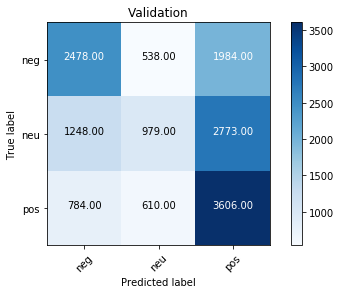

f1 score 0.47086666666666666
Accuracy 0.47086666666666666
INFO:tensorflow:Writing example 0 of 300


I0519 19:22:24.001038 140591241648000 run_classifier.py:774] Writing example 0 of 300


INFO:tensorflow:*** Example ***


I0519 19:22:24.003697 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:22:24.006435 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] the product that i received is in great condition however , it didn ' t come as quickly as i expected . would recommend using again . [SEP]


I0519 19:22:24.010275 140591241648000 run_classifier.py:464] tokens: [CLS] the product that i received is in great condition however , it didn ' t come as quickly as i expected . would recommend using again . [SEP]


INFO:tensorflow:input_ids: 101 1996 4031 2008 1045 2363 2003 1999 2307 4650 2174 1010 2009 2134 1005 1056 2272 2004 2855 2004 1045 3517 1012 2052 16755 2478 2153 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:24.014295 140591241648000 run_classifier.py:465] input_ids: 101 1996 4031 2008 1045 2363 2003 1999 2307 4650 2174 1010 2009 2134 1005 1056 2272 2004 2855 2004 1045 3517 1012 2052 16755 2478 2153 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:24.020230 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:24.022313 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:22:24.024660 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0519 19:22:24.029555 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:22:24.037110 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this rates as my all time worst hd video transfer , i would not be surprised to find that it has been transfer ##ed from a vhs version of the movie as it is so bad . there is bucket loads of grain , total lack of definition it is just absolutely terrible . [SEP]


I0519 19:22:24.040113 140591241648000 run_classifier.py:464] tokens: [CLS] this rates as my all time worst hd video transfer , i would not be surprised to find that it has been transfer ##ed from a vhs version of the movie as it is so bad . there is bucket loads of grain , total lack of definition it is just absolutely terrible . [SEP]


INFO:tensorflow:input_ids: 101 2023 6165 2004 2026 2035 2051 5409 10751 2678 4651 1010 1045 2052 2025 2022 4527 2000 2424 2008 2009 2038 2042 4651 2098 2013 1037 17550 2544 1997 1996 3185 2004 2009 2003 2061 2919 1012 2045 2003 13610 15665 1997 8982 1010 2561 3768 1997 6210 2009 2003 2074 7078 6659 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:24.042279 140591241648000 run_classifier.py:465] input_ids: 101 2023 6165 2004 2026 2035 2051 5409 10751 2678 4651 1010 1045 2052 2025 2022 4527 2000 2424 2008 2009 2038 2042 4651 2098 2013 1037 17550 2544 1997 1996 3185 2004 2009 2003 2061 2919 1012 2045 2003 13610 15665 1997 8982 1010 2561 3768 1997 6210 2009 2003 2074 7078 6659 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:24.043872 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:24.048757 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Negative (id = 0)


I0519 19:22:24.050391 140591241648000 run_classifier.py:468] label: Negative (id = 0)


INFO:tensorflow:*** Example ***


I0519 19:22:24.057971 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:22:24.064853 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] the car chase is one of the most in ##ex ##pl ##ica ##ble scenes i have seen on film . what is going on ? is it exciting ? dar ##ned if i know . it was just a lot of quick cuts . the director needed to sit and watch ronin again - - - driving against traffic is impressive visually , but only if you can actually see what ' s going on ! < br / > < br / > okay , ran ##t over . the bourne identity is one of the best , intelligent action movies of recent years . this sequel is watch ##able , matt damon does a quite reasonable job , but a pale shadow of the [SEP]


I0519 19:22:24.066600 140591241648000 run_classifier.py:464] tokens: [CLS] the car chase is one of the most in ##ex ##pl ##ica ##ble scenes i have seen on film . what is going on ? is it exciting ? dar ##ned if i know . it was just a lot of quick cuts . the director needed to sit and watch ronin again - - - driving against traffic is impressive visually , but only if you can actually see what ' s going on ! < br / > < br / > okay , ran ##t over . the bourne identity is one of the best , intelligent action movies of recent years . this sequel is watch ##able , matt damon does a quite reasonable job , but a pale shadow of the [SEP]


INFO:tensorflow:input_ids: 101 1996 2482 5252 2003 2028 1997 1996 2087 1999 10288 24759 5555 3468 5019 1045 2031 2464 2006 2143 1012 2054 2003 2183 2006 1029 2003 2009 10990 1029 18243 7228 2065 1045 2113 1012 2009 2001 2074 1037 2843 1997 4248 7659 1012 1996 2472 2734 2000 4133 1998 3422 29249 2153 1011 1011 1011 4439 2114 4026 2003 8052 17453 1010 2021 2069 2065 2017 2064 2941 2156 2054 1005 1055 2183 2006 999 1026 7987 1013 1028 1026 7987 1013 1028 3100 1010 2743 2102 2058 1012 1996 15803 4767 2003 2028 1997 1996 2190 1010 9414 2895 5691 1997 3522 2086 1012 2023 8297 2003 3422 3085 1010 4717 11317 2515 1037 3243 9608 3105 1010 2021 1037 5122 5192 1997 1996 102


I0519 19:22:24.069112 140591241648000 run_classifier.py:465] input_ids: 101 1996 2482 5252 2003 2028 1997 1996 2087 1999 10288 24759 5555 3468 5019 1045 2031 2464 2006 2143 1012 2054 2003 2183 2006 1029 2003 2009 10990 1029 18243 7228 2065 1045 2113 1012 2009 2001 2074 1037 2843 1997 4248 7659 1012 1996 2472 2734 2000 4133 1998 3422 29249 2153 1011 1011 1011 4439 2114 4026 2003 8052 17453 1010 2021 2069 2065 2017 2064 2941 2156 2054 1005 1055 2183 2006 999 1026 7987 1013 1028 1026 7987 1013 1028 3100 1010 2743 2102 2058 1012 1996 15803 4767 2003 2028 1997 1996 2190 1010 9414 2895 5691 1997 3522 2086 1012 2023 8297 2003 3422 3085 1010 4717 11317 2515 1037 3243 9608 3105 1010 2021 1037 5122 5192 1997 1996 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0519 19:22:24.071670 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:24.074751 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:22:24.077404 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0519 19:22:24.082638 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:22:24.085472 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] its a cheese ##y early 80 ' s sci ##fi . . . i saw in the movies when it 1st came out . never heard about it or saw it again till i got the dvd . they def ##ina ##tly did not clean this up digitally . looks crap ##py . but i wanted it now i have it ! . . if you like this type of movie than buy it ! ! [SEP]


I0519 19:22:24.088255 140591241648000 run_classifier.py:464] tokens: [CLS] its a cheese ##y early 80 ' s sci ##fi . . . i saw in the movies when it 1st came out . never heard about it or saw it again till i got the dvd . they def ##ina ##tly did not clean this up digitally . looks crap ##py . but i wanted it now i have it ! . . if you like this type of movie than buy it ! ! [SEP]


INFO:tensorflow:input_ids: 101 2049 1037 8808 2100 2220 3770 1005 1055 16596 8873 1012 1012 1012 1045 2387 1999 1996 5691 2043 2009 3083 2234 2041 1012 2196 2657 2055 2009 2030 2387 2009 2153 6229 1045 2288 1996 4966 1012 2027 13366 3981 14626 2106 2025 4550 2023 2039 18397 1012 3504 10231 7685 1012 2021 1045 2359 2009 2085 1045 2031 2009 999 1012 1012 2065 2017 2066 2023 2828 1997 3185 2084 4965 2009 999 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:24.091162 140591241648000 run_classifier.py:465] input_ids: 101 2049 1037 8808 2100 2220 3770 1005 1055 16596 8873 1012 1012 1012 1045 2387 1999 1996 5691 2043 2009 3083 2234 2041 1012 2196 2657 2055 2009 2030 2387 2009 2153 6229 1045 2288 1996 4966 1012 2027 13366 3981 14626 2106 2025 4550 2023 2039 18397 1012 3504 10231 7685 1012 2021 1045 2359 2009 2085 1045 2031 2009 999 1012 1012 2065 2017 2066 2023 2828 1997 3185 2084 4965 2009 999 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:24.093942 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:24.096756 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:22:24.099467 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0519 19:22:24.114081 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:22:24.117430 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this is one of those movies that is bad but fun to watch anyway . a couple of teenagers and then the local garage owner disappear and it turns out the cu ##lp ##rit is a giant lizard that somehow exists for weeks with no one noticing . no explanation is ever given as to where the lizard came from or why or how no one saw something that was big enough to der ##ail a train with its head . < br / > < br / > there is too much time spent on the main character and his problems and little spent on creating any actual tension with the lizard . the effects are what you would expect , a regular sized lizard [SEP]


I0519 19:22:24.120049 140591241648000 run_classifier.py:464] tokens: [CLS] this is one of those movies that is bad but fun to watch anyway . a couple of teenagers and then the local garage owner disappear and it turns out the cu ##lp ##rit is a giant lizard that somehow exists for weeks with no one noticing . no explanation is ever given as to where the lizard came from or why or how no one saw something that was big enough to der ##ail a train with its head . < br / > < br / > there is too much time spent on the main character and his problems and little spent on creating any actual tension with the lizard . the effects are what you would expect , a regular sized lizard [SEP]


INFO:tensorflow:input_ids: 101 2023 2003 2028 1997 2216 5691 2008 2003 2919 2021 4569 2000 3422 4312 1012 1037 3232 1997 12908 1998 2059 1996 2334 7381 3954 10436 1998 2009 4332 2041 1996 12731 14277 14778 2003 1037 5016 15450 2008 5064 6526 2005 3134 2007 2053 2028 15103 1012 2053 7526 2003 2412 2445 2004 2000 2073 1996 15450 2234 2013 2030 2339 2030 2129 2053 2028 2387 2242 2008 2001 2502 2438 2000 4315 12502 1037 3345 2007 2049 2132 1012 1026 7987 1013 1028 1026 7987 1013 1028 2045 2003 2205 2172 2051 2985 2006 1996 2364 2839 1998 2010 3471 1998 2210 2985 2006 4526 2151 5025 6980 2007 1996 15450 1012 1996 3896 2024 2054 2017 2052 5987 1010 1037 3180 7451 15450 102


I0519 19:22:24.122608 140591241648000 run_classifier.py:465] input_ids: 101 2023 2003 2028 1997 2216 5691 2008 2003 2919 2021 4569 2000 3422 4312 1012 1037 3232 1997 12908 1998 2059 1996 2334 7381 3954 10436 1998 2009 4332 2041 1996 12731 14277 14778 2003 1037 5016 15450 2008 5064 6526 2005 3134 2007 2053 2028 15103 1012 2053 7526 2003 2412 2445 2004 2000 2073 1996 15450 2234 2013 2030 2339 2030 2129 2053 2028 2387 2242 2008 2001 2502 2438 2000 4315 12502 1037 3345 2007 2049 2132 1012 1026 7987 1013 1028 1026 7987 1013 1028 2045 2003 2205 2172 2051 2985 2006 1996 2364 2839 1998 2010 3471 1998 2210 2985 2006 4526 2151 5025 6980 2007 1996 15450 1012 1996 3896 2024 2054 2017 2052 5987 1010 1037 3180 7451 15450 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0519 19:22:24.125267 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:24.127878 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Negative (id = 0)


I0519 19:22:24.129992 140591241648000 run_classifier.py:468] label: Negative (id = 0)


INFO:tensorflow:Writing example 0 of 15000


I0519 19:22:25.282605 140591241648000 run_classifier.py:774] Writing example 0 of 15000


INFO:tensorflow:*** Example ***


I0519 19:22:25.296446 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:22:25.298186 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] while i enjoy ra ##un ##chy , un ##pre ##ten ##tious comedies as much as the next guy , i generally like them to be funny . and smart . " team america : world police " isn ' t much of either . oh , there are a few bits i gu ##ffa ##wed it , not limited to the infamous , graphic puppet sex scene , which lamp ##oons , among other things , the mp ##aa ' s rather narrow - minded view that showing sex without gen ##ital ##s will somehow be less problematic than showing sex with . kim jong il is a ho ##ot , about the only aspect consistently amusing , though he ' s so much like saddam [SEP]


I0519 19:22:25.300346 140591241648000 run_classifier.py:464] tokens: [CLS] while i enjoy ra ##un ##chy , un ##pre ##ten ##tious comedies as much as the next guy , i generally like them to be funny . and smart . " team america : world police " isn ' t much of either . oh , there are a few bits i gu ##ffa ##wed it , not limited to the infamous , graphic puppet sex scene , which lamp ##oons , among other things , the mp ##aa ' s rather narrow - minded view that showing sex without gen ##ital ##s will somehow be less problematic than showing sex with . kim jong il is a ho ##ot , about the only aspect consistently amusing , though he ' s so much like saddam [SEP]


INFO:tensorflow:input_ids: 101 2096 1045 5959 10958 4609 11714 1010 4895 28139 6528 20771 22092 2004 2172 2004 1996 2279 3124 1010 1045 3227 2066 2068 2000 2022 6057 1012 1998 6047 1012 1000 2136 2637 1024 2088 2610 1000 3475 1005 1056 2172 1997 2593 1012 2821 1010 2045 2024 1037 2261 9017 1045 19739 20961 15557 2009 1010 2025 3132 2000 1996 14429 1010 8425 13997 3348 3496 1010 2029 10437 27174 1010 2426 2060 2477 1010 1996 6131 11057 1005 1055 2738 4867 1011 13128 3193 2008 4760 3348 2302 8991 18400 2015 2097 5064 2022 2625 18636 2084 4760 3348 2007 1012 5035 18528 6335 2003 1037 7570 4140 1010 2055 1996 2069 7814 10862 19142 1010 2295 2002 1005 1055 2061 2172 2066 24111 102


I0519 19:22:25.303284 140591241648000 run_classifier.py:465] input_ids: 101 2096 1045 5959 10958 4609 11714 1010 4895 28139 6528 20771 22092 2004 2172 2004 1996 2279 3124 1010 1045 3227 2066 2068 2000 2022 6057 1012 1998 6047 1012 1000 2136 2637 1024 2088 2610 1000 3475 1005 1056 2172 1997 2593 1012 2821 1010 2045 2024 1037 2261 9017 1045 19739 20961 15557 2009 1010 2025 3132 2000 1996 14429 1010 8425 13997 3348 3496 1010 2029 10437 27174 1010 2426 2060 2477 1010 1996 6131 11057 1005 1055 2738 4867 1011 13128 3193 2008 4760 3348 2302 8991 18400 2015 2097 5064 2022 2625 18636 2084 4760 3348 2007 1012 5035 18528 6335 2003 1037 7570 4140 1010 2055 1996 2069 7814 10862 19142 1010 2295 2002 1005 1055 2061 2172 2066 24111 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0519 19:22:25.307398 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:25.310000 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:22:25.314012 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0519 19:22:25.318748 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:22:25.321115 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this film had better be good ! be ##cous ##e it looks from the pre ##ve ##ws to ##be a remake of the 1973 / 1975 classic logan ' s run only they have renamed it . everything else is the same . you ##ed better be good ! cu ##se the original is a classic ! ! ! ! ! ! thanks . [SEP]


I0519 19:22:25.325570 140591241648000 run_classifier.py:464] tokens: [CLS] this film had better be good ! be ##cous ##e it looks from the pre ##ve ##ws to ##be a remake of the 1973 / 1975 classic logan ' s run only they have renamed it . everything else is the same . you ##ed better be good ! cu ##se the original is a classic ! ! ! ! ! ! thanks . [SEP]


INFO:tensorflow:input_ids: 101 2023 2143 2018 2488 2022 2204 999 2022 27199 2063 2009 3504 2013 1996 3653 3726 9333 2000 4783 1037 12661 1997 1996 3381 1013 3339 4438 6307 1005 1055 2448 2069 2027 2031 4096 2009 1012 2673 2842 2003 1996 2168 1012 2017 2098 2488 2022 2204 999 12731 3366 1996 2434 2003 1037 4438 999 999 999 999 999 999 4283 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:25.328052 140591241648000 run_classifier.py:465] input_ids: 101 2023 2143 2018 2488 2022 2204 999 2022 27199 2063 2009 3504 2013 1996 3653 3726 9333 2000 4783 1037 12661 1997 1996 3381 1013 3339 4438 6307 1005 1055 2448 2069 2027 2031 4096 2009 1012 2673 2842 2003 1996 2168 1012 2017 2098 2488 2022 2204 999 12731 3366 1996 2434 2003 1037 4438 999 999 999 999 999 999 4283 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:25.332405 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:25.335484 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0519 19:22:25.338875 140591241648000 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0519 19:22:25.350806 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:22:25.352912 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this is a story of three sailors ( gene kelly , frank sinatra and jules mu ##nch ##in ) and their es ##cap ##ades while on shore leave for 24 hours in new york - a much worked hollywood theme ! it was originally a broadway hit with music by leonard bernstein and lyrics by betty com ##den and adolph green , itself a re ##working of a jerome robbins ballet called fancy free . gene kelly directed and choreographed the film with stanley done ##n . some of the bernstein tunes were dropped in the film to be replaced by others composed by roger eden ##s , conrad sal ##inger and len ##nie hay ##ton . but the ro ##using opening number , ` new [SEP]


I0519 19:22:25.356150 140591241648000 run_classifier.py:464] tokens: [CLS] this is a story of three sailors ( gene kelly , frank sinatra and jules mu ##nch ##in ) and their es ##cap ##ades while on shore leave for 24 hours in new york - a much worked hollywood theme ! it was originally a broadway hit with music by leonard bernstein and lyrics by betty com ##den and adolph green , itself a re ##working of a jerome robbins ballet called fancy free . gene kelly directed and choreographed the film with stanley done ##n . some of the bernstein tunes were dropped in the film to be replaced by others composed by roger eden ##s , conrad sal ##inger and len ##nie hay ##ton . but the ro ##using opening number , ` new [SEP]


INFO:tensorflow:input_ids: 101 2023 2003 1037 2466 1997 2093 11279 1006 4962 5163 1010 3581 19643 1998 11044 14163 12680 2378 1007 1998 2037 9686 17695 18673 2096 2006 5370 2681 2005 2484 2847 1999 2047 2259 1011 1037 2172 2499 5365 4323 999 2009 2001 2761 1037 5934 2718 2007 2189 2011 7723 18862 1998 4581 2011 9306 4012 4181 1998 28564 2665 1010 2993 1037 2128 21398 1997 1037 11120 18091 7250 2170 11281 2489 1012 4962 5163 2856 1998 23317 1996 2143 2007 6156 2589 2078 1012 2070 1997 1996 18862 13281 2020 3333 1999 1996 2143 2000 2022 2999 2011 2500 3605 2011 5074 10267 2015 1010 10931 16183 9912 1998 18798 8034 10974 2669 1012 2021 1996 20996 18161 3098 2193 1010 1036 2047 102


I0519 19:22:25.359811 140591241648000 run_classifier.py:465] input_ids: 101 2023 2003 1037 2466 1997 2093 11279 1006 4962 5163 1010 3581 19643 1998 11044 14163 12680 2378 1007 1998 2037 9686 17695 18673 2096 2006 5370 2681 2005 2484 2847 1999 2047 2259 1011 1037 2172 2499 5365 4323 999 2009 2001 2761 1037 5934 2718 2007 2189 2011 7723 18862 1998 4581 2011 9306 4012 4181 1998 28564 2665 1010 2993 1037 2128 21398 1997 1037 11120 18091 7250 2170 11281 2489 1012 4962 5163 2856 1998 23317 1996 2143 2007 6156 2589 2078 1012 2070 1997 1996 18862 13281 2020 3333 1999 1996 2143 2000 2022 2999 2011 2500 3605 2011 5074 10267 2015 1010 10931 16183 9912 1998 18798 8034 10974 2669 1012 2021 1996 20996 18161 3098 2193 1010 1036 2047 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0519 19:22:25.362980 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:25.366101 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Positive (id = 2)


I0519 19:22:25.370024 140591241648000 run_classifier.py:468] label: Positive (id = 2)


INFO:tensorflow:*** Example ***


I0519 19:22:25.374106 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:22:25.377350 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] loved the books and movies . wish they had bundled part 1 and 2 together earlier . < br / > my kids have watched the movies multiple times and still enjoy it ! [SEP]


I0519 19:22:25.381012 140591241648000 run_classifier.py:464] tokens: [CLS] loved the books and movies . wish they had bundled part 1 and 2 together earlier . < br / > my kids have watched the movies multiple times and still enjoy it ! [SEP]


INFO:tensorflow:input_ids: 101 3866 1996 2808 1998 5691 1012 4299 2027 2018 24378 2112 1015 1998 1016 2362 3041 1012 1026 7987 1013 1028 2026 4268 2031 3427 1996 5691 3674 2335 1998 2145 5959 2009 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:25.383785 140591241648000 run_classifier.py:465] input_ids: 101 3866 1996 2808 1998 5691 1012 4299 2027 2018 24378 2112 1015 1998 1016 2362 3041 1012 1026 7987 1013 1028 2026 4268 2031 3427 1996 5691 3674 2335 1998 2145 5959 2009 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:25.386491 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:25.390369 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Positive (id = 2)


I0519 19:22:25.393722 140591241648000 run_classifier.py:468] label: Positive (id = 2)


INFO:tensorflow:*** Example ***


I0519 19:22:25.409462 140591241648000 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0519 19:22:25.411475 140591241648000 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] i saw " the wedding crash ##ers " the other day . i had a great time and thought it was very funny . it ' s important to point this out because i want to give an example of a recent comedy i thought was good . later on that night i watched the adam sand ##ler remake of the 1974 burt reynolds comedy " the longest yard . " adam sand ##ler is not burt reynolds ( who is also in this version ) and he never will be . if he has acting ability this movie doesn ' t make it known . don ' t get me wrong . i liked some of his earlier films such as " the water ##boy [SEP]


I0519 19:22:25.415460 140591241648000 run_classifier.py:464] tokens: [CLS] i saw " the wedding crash ##ers " the other day . i had a great time and thought it was very funny . it ' s important to point this out because i want to give an example of a recent comedy i thought was good . later on that night i watched the adam sand ##ler remake of the 1974 burt reynolds comedy " the longest yard . " adam sand ##ler is not burt reynolds ( who is also in this version ) and he never will be . if he has acting ability this movie doesn ' t make it known . don ' t get me wrong . i liked some of his earlier films such as " the water ##boy [SEP]


INFO:tensorflow:input_ids: 101 1045 2387 1000 1996 5030 5823 2545 1000 1996 2060 2154 1012 1045 2018 1037 2307 2051 1998 2245 2009 2001 2200 6057 1012 2009 1005 1055 2590 2000 2391 2023 2041 2138 1045 2215 2000 2507 2019 2742 1997 1037 3522 4038 1045 2245 2001 2204 1012 2101 2006 2008 2305 1045 3427 1996 4205 5472 3917 12661 1997 1996 3326 18611 9579 4038 1000 1996 6493 4220 1012 1000 4205 5472 3917 2003 2025 18611 9579 1006 2040 2003 2036 1999 2023 2544 1007 1998 2002 2196 2097 2022 1012 2065 2002 2038 3772 3754 2023 3185 2987 1005 1056 2191 2009 2124 1012 2123 1005 1056 2131 2033 3308 1012 1045 4669 2070 1997 2010 3041 3152 2107 2004 1000 1996 2300 11097 102


I0519 19:22:25.418360 140591241648000 run_classifier.py:465] input_ids: 101 1045 2387 1000 1996 5030 5823 2545 1000 1996 2060 2154 1012 1045 2018 1037 2307 2051 1998 2245 2009 2001 2200 6057 1012 2009 1005 1055 2590 2000 2391 2023 2041 2138 1045 2215 2000 2507 2019 2742 1997 1037 3522 4038 1045 2245 2001 2204 1012 2101 2006 2008 2305 1045 3427 1996 4205 5472 3917 12661 1997 1996 3326 18611 9579 4038 1000 1996 6493 4220 1012 1000 4205 5472 3917 2003 2025 18611 9579 1006 2040 2003 2036 1999 2023 2544 1007 1998 2002 2196 2097 2022 1012 2065 2002 2038 3772 3754 2023 3185 2987 1005 1056 2191 2009 2124 1012 2123 1005 1056 2131 2033 3308 1012 1045 4669 2070 1997 2010 3041 3152 2107 2004 1000 1996 2300 11097 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0519 19:22:25.421515 140591241648000 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0519 19:22:25.423192 140591241648000 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Negative (id = 0)


I0519 19:22:25.425929 140591241648000 run_classifier.py:468] label: Negative (id = 0)


INFO:tensorflow:Writing example 10000 of 15000


I0519 19:23:05.458746 140591241648000 run_classifier.py:774] Writing example 10000 of 15000


In [0]:
f1_scores = []
for task in tasks:
  for subtask in sub_tasks:
    f1_column = []
    for LEARNING_RATE in learning_rates:
      for NUM_TRAIN_EPOCHS in epochs:

        df_trn = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/"+task+"/"+subtask+"/train.csv")
        df_tst = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/"+task+"/"+subtask+"/validate.csv")

        df_trn = df_trn[["text", "label"]]
        df_tst = df_tst[["text", "label"]]

        df_trn['text'] = df_trn['text'].astype(str)
        df_tst['text'] = df_tst['text'].astype(str)

        df_trn = df_trn.sample(frac=1)
        df_tst = df_tst.sample(frac=1)

        train_InputExamples = df_trn.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                           text_a = x[DATA_COLUMN], 
                                                                           text_b = None, 
                                                                           label = x[LABEL_COLUMN]), axis = 1)

        test_InputExamples = df_tst.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                           text_a = x[DATA_COLUMN], 
                                                                           text_b = None, 
                                                                           label = x[LABEL_COLUMN]), axis = 1)


        # Convert our train and test features to InputFeatures that BERT understands.
        train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
        test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

        # Specify outpit directory and number of checkpoint steps to save
        run_config = tf.estimator.RunConfig(
            model_dir="model",
            save_summary_steps=SAVE_SUMMARY_STEPS,
            save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

        # Create an input function for training. drop_remainder = True for using TPUs.
        train_input_fn = bert.run_classifier.input_fn_builder(
            features=train_features,
            seq_length=MAX_SEQ_LENGTH,
            is_training=True,
            drop_remainder=False)

        # Compute # train and warmup steps from batch size
        num_train_steps = int((len(train_features) / BATCH_SIZE) * NUM_TRAIN_EPOCHS)
        num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
        print(num_train_steps)
        print(num_warmup_steps)


        model_fn = model_fn_builder(
            num_labels=len(label_list),
            learning_rate=LEARNING_RATE,
            num_train_steps=num_train_steps,
            num_warmup_steps=num_warmup_steps)

        estimator = tf.estimator.Estimator(
            model_fn=model_fn,
            config=run_config,
            params={"batch_size": BATCH_SIZE})

        print(f'Beginning Training!')
        current_time = datetime.now()
        estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
        print("Training took time ", datetime.now() - current_time)

        test_input_fn = run_classifier.input_fn_builder(
            features=test_features,
            seq_length=MAX_SEQ_LENGTH,
            is_training=False,
            drop_remainder=False)

        predictions = get_prediction(df_tst[DATA_COLUMN])
        pred_labels = [pred[2] for pred in predictions]


        cm_test = confusion_matrix(y_true=df_tst["label"], y_pred=pred_labels)
        plot_confusion_matrix(cm_test,
                              ['neg', 'neu', 'pos'],
                              normalize=False,
                              title='Validation')
        print("f1 score", f1_score(df_tst["label"], pred_labels, average="micro"))
        print("Accuracy", accuracy_score(df_tst["label"], pred_labels))

        f1_column.append(f1_score(df_tst["label"], pred_labels, average="micro"))
    f1_scores.append(f1_column) 

In [0]:
pd.DataFrame(np.array(f1_scores).T)


In [0]:
df_trn = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/"+task+"/"+subtask+"/train.csv")
df_val = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/"+task+"/"+subtask+"/validate.csv")

In [15]:
df_val

,text,label
7572,"Sigh, Hulk Hogan is in the news again for the ...",Negative
2935,*Chandigarh is the Capital of the two states o...,Neutral
7950,Casinos in Atlantic City closed since Sunday b...,Negative
659,@sebroche rocking some U2 at the Saturday Nigh...,Neutral
2426,Leaving the N.O. early tomorrow to get to Hamm...,Neutral
6732,@BarackObama is the 1st to call a Black man a ...,Negative
5458,3 episodes of Family Guy tonight on BBC3. Put ...,Positive
1889,Going to Planned Parenthood on Monday because ...,Neutral
4308,"Took son to see Jurassic Park when he was 5, w...",Positive
7726,"Just sat through twilight, what's going on wit...",Negative


Now the below is just an adhoc example of what we can do to evaluate this

In [11]:
task

'amazon_movies'

Now we can predict completely made up adhoc examples:

In [13]:
subtask

'fair_balanced_1000'

In [0]:
df_tst

,text,label
9516,"If you like Jim Carrey, and want to see him in...",Neutral
11298,Okay let's start at the beginning.<p>1)The sto...,Negative
9350,This is a classic musical film and I have noth...,Neutral
1902,I saw this video at a party and enjoyed it so ...,Positive
10826,Let me see if I have this straight. Madeline'...,Negative
3379,The film Boodock Saints can be considered a cu...,Positive
3654,"Good movie, done in a very stylish, classy way...",Positive
10443,What a disappointment. My grand kids love the...,Negative
10139,This was truly a waste of film and time. You w...,Negative
322,I have the entire set of Carmen Electra's Stri...,Positive


Voila! We have a sentiment classifier!

In [0]:
predictions[0][2]